Load the test dataset and arrange them in descending order of median latency. 

In [1]:
import pickle
import numpy as np

test_data_directory = "../../../training_data/data/task_from_graph_test.pkl"
with open(test_data_directory, 'rb') as f:
    filtered_iso_test = pickle.load(f)

import numpy as np

def median_of_y(same_graph_list):
    y_values = []
    for unique_map in same_graph_list:
        y_values.append(unique_map.y)
    return np.median(y_values)

filtered_iso_test.sort(key=median_of_y, reverse=True)

list_of_ground_truth = []

for same_graph_list in filtered_iso_test:
    list_of_ground_truth.append(median_of_y(same_graph_list))

Defining Inference Functions

In [2]:
import torch
from mean.model import GCN

def do_inference(data, model_path, input_features=3):
    model_state_dict = torch.load(model_path,  map_location=torch.device('cpu'))
    model =  GCN(num_node_features=input_features).to(torch.device('cpu'))
    model.load_state_dict(model_state_dict)
    pred_latency = model(data.x, data.edge_index, data.batch)
    actual_latency = data.y
    model.load_state_dict(model_state_dict)
    return pred_latency, actual_latency

data = filtered_iso_test[0][0]
pred, actual = do_inference(data, "mean/LatNet_100_state_dict.pth")

print(f"Predicted latency: {pred}")
print(f"Actual latency: {actual}")

Predicted latency: tensor([[2389.0938]], grad_fn=<AddmmBackward0>)
Actual latency: tensor([2386.])


In [3]:
# Box Plot  
list_of_latency_list = []

mean_latency_list = []
no_outlier_latency_list = []
iqr_latency_list = []
upto_q2 = []

for same_graph in filtered_iso_test:
    latency_list = []
    to_infer = True
    for graph in same_graph:
        latency_list.append(graph.y.item())
        if to_infer:
            mean_pred, _ = do_inference(graph, "mean/LatNet_2000_state_dict.pth")
            mean_latency_list.append(mean_pred.item())

            no_outlier_pred, _ = do_inference(graph, "no_outliers/LatNet_1500_state_dict.pth")
            no_outlier_latency_list.append(no_outlier_pred.item())

            iqr_pred, _ = do_inference(graph, "iqr/LatNet_1500_state_dict.pth")
            iqr_latency_list.append(iqr_pred.item())

            upto_q2_pred, _ = do_inference(graph, "upto_q2/LatNet_250_state_dict.pth")
            upto_q2.append(upto_q2_pred.item())

            to_infer = False
    list_of_latency_list.append(latency_list)

### Evaluation
1. Plotting the Inference 


Text(0, 0.5, 'Latency')

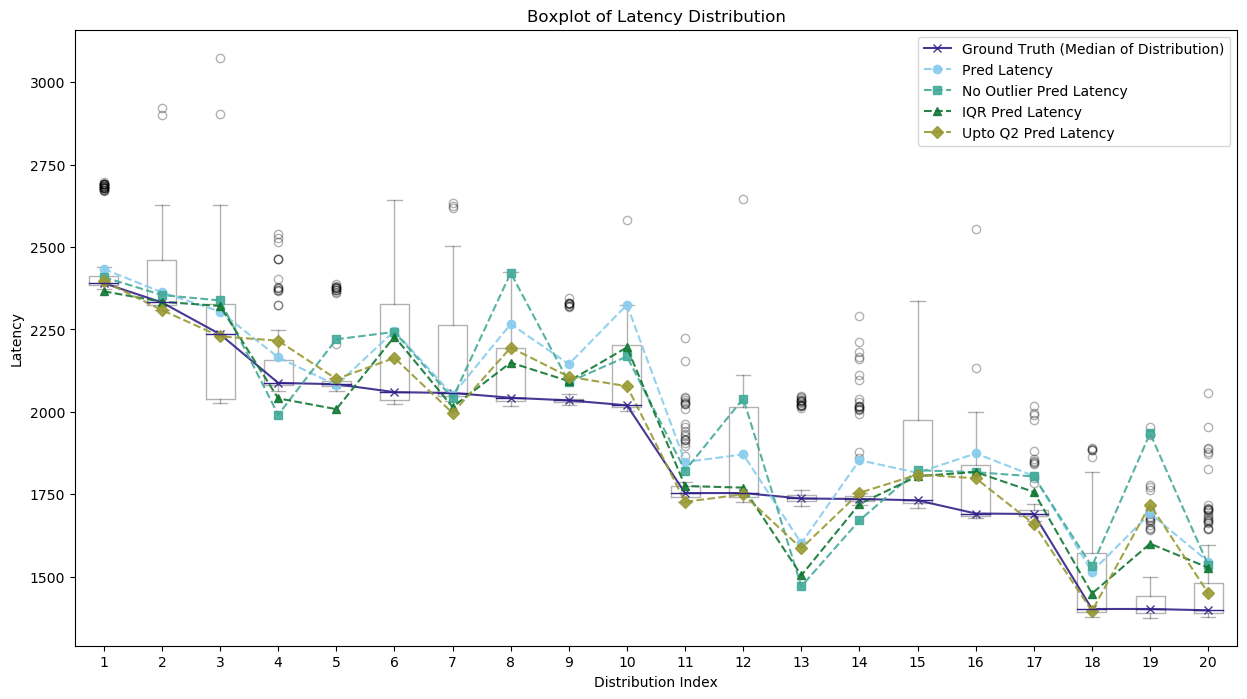

In [4]:
import matplotlib.pyplot as plt
import numpy as np

color_cycle = [
    '#332288', 
    '#88CCEE', 
    '#44AA99', 
    '#117733', 
    '#999933', 
    '#DDCC77', 
    '#CC6677', 
    '#882255', 
    '#AA4499'
]

fig, ax = plt.subplots(figsize=(15, 8))
num_of_test_data = len(list_of_latency_list)

alpha_value_boxplot = 0.3
boxplot = ax.boxplot(
    list_of_latency_list,
    medianprops={'color': color_cycle[0]},
    boxprops={'color': 'black', 'alpha': alpha_value_boxplot},
    whiskerprops={'color': 'black', 'alpha': alpha_value_boxplot},
    capprops={'color': 'black', 'alpha': alpha_value_boxplot},
    flierprops={'marker': 'o', 'color': 'black', 'alpha': alpha_value_boxplot}
)

alpha_value_line_plots = 0.9

line0, = ax.plot(
    np.arange(1, num_of_test_data + 1), 
    list_of_ground_truth, 
    color=color_cycle[0], 
    marker='x', 
    linestyle='-', 
    label='Ground Truth (Median of Distribution)', 
    alpha=alpha_value_line_plots
)

line1, = ax.plot(
    np.arange(1, num_of_test_data + 1), 
    mean_latency_list, 
    color=color_cycle[1], 
    marker='o', 
    linestyle='--', 
    label='Pred Latency', 
    alpha=alpha_value_line_plots
)

line2, = ax.plot(
    np.arange(1, num_of_test_data + 1), 
    no_outlier_latency_list, 
    color=color_cycle[2], 
    marker='s', 
    linestyle='--', 
    label='No Outlier Pred Latency', 
    alpha=alpha_value_line_plots
)

line3, = ax.plot(
    np.arange(1, num_of_test_data + 1), 
    iqr_latency_list, 
    color=color_cycle[3], 
    marker='^', 
    linestyle='--', 
    label='IQR Pred Latency', 
    alpha=alpha_value_line_plots
)

line4, = ax.plot(
    np.arange(1, num_of_test_data + 1), 
    upto_q2, 
    color=color_cycle[4], 
    marker='D', 
    linestyle='--', 
    label='Upto Q2 Pred Latency', 
    alpha=alpha_value_line_plots
)

ax.legend()
ax.set_title('Boxplot of Latency Distribution')
ax.set_xlabel('Distribution Index')
ax.set_ylabel('Latency')

#import tikzplotlib
#tikzplotlib.save("boxplot.tex")

2. Regression 

In [5]:
rmse_mean = np.sqrt(np.mean((np.array(mean_latency_list) - np.array(list_of_ground_truth))**2))
print(f"all: \t\t{rmse_mean}")

rmse_no_outlier = np.sqrt(np.mean((np.array(no_outlier_latency_list) - np.array(list_of_ground_truth))**2))
print(f"no_outlier: \t{rmse_no_outlier}")

rmse_iqr = np.sqrt(np.mean((np.array(iqr_latency_list) - np.array(list_of_ground_truth))**2))
print(f"iqr: \t\t{rmse_iqr}")

rmse_upto_q2 = np.sqrt(np.mean((np.array(upto_q2) - np.array(list_of_ground_truth))**2))
print(f"upto_q2: \t{rmse_upto_q2}")

all: 		146.59899084881127
no_outlier: 	194.80611244662865
iqr: 		107.4200979943908
upto_q2: 	102.08901103606412


3. Classification 

In [19]:
threshold_percentage = 0.05
total_instances = len(list_of_ground_truth)

def is_within_threshold(prediction, actual):
    threshold = actual * threshold_percentage
    lower_bound = actual - threshold
    upper_bound = actual + threshold
    return lower_bound <= prediction <= upper_bound

true_positives_mean = 0
true_positives_no_outlier = 0
true_positives_iqr = 0
true_positives_upto_q2 = 0

for (mean_pred,         
     no_outlier_pred,   
     iqr_pred,          
     upto_q2_pred,      
     actual_latency     
    ) in zip(
        mean_latency_list, 
        no_outlier_latency_list, 
        iqr_latency_list, 
        upto_q2, 
        list_of_ground_truth
    ):

    if is_within_threshold(mean_pred, actual_latency):
        true_positives_mean += 1
    if is_within_threshold(no_outlier_pred, actual_latency):
        true_positives_no_outlier += 1
    if is_within_threshold(iqr_pred, actual_latency):
        true_positives_iqr += 1
    if is_within_threshold(upto_q2_pred, actual_latency):
        true_positives_upto_q2 += 1

accuracy_mean = true_positives_mean / total_instances
accuracy_no_outlier = true_positives_no_outlier / total_instances
accuracy_iqr = true_positives_iqr / total_instances
accuracy_upto_q2 = true_positives_upto_q2 / total_instances

print(f"all: \t\t{accuracy_mean:.2%}")
print(f"no_outlier: \t{accuracy_no_outlier:.2%}")
print(f"iqr: \t\t{accuracy_iqr:.2%}")
print(f"upto_q2: \t{accuracy_upto_q2:.2%}")


all: 		35.00%
no_outlier: 	40.00%
iqr: 		65.00%
upto_q2: 	70.00%
